## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Salih Eren Yüzbaşıoğlu 2220356040

## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
In this assignment, we have a dataset containing movie reviews. The dataset has two columns: review and sentiment. The sentiment column has two classes: 0 and 1, where 0 represents a negative review and 1 represents a positive review. Load the data and display the first 5 rows. Review are strings that express the sentiment of the review. Our task is to predict the sentiment of the review using LSTM.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
import re 
import spacy 

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt_tab')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\algos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


device(type='cuda')

In [2]:
# Load the data into pandas a dataframe
# Represent the sentiments in a meaningful numerical form
# Check the first few rows
import pandas as pd
# subset10000_IMDB_Dataset.csv
data = pd.read_csv('subset10000_IMDB_Dataset.csv')
# change setiment to 0 and 1
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data.head()

,review,sentiment
0,"Starts really well, nice intro and build up fo...",0
1,"Terrific movie: If you did not watch yet, you ...",1
2,I've seen hundreds of silent movies. Some will...,1
3,i had been looking for this film for so long b...,1
4,"Good: Engaging cinematic firefights, great pre...",1


In [3]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.

print(data.shape)
print(data.columns)
print(data['sentiment'].value_counts())
print("nulls: " , data.isnull().sum())

(10000, 2)
Index(['review', 'sentiment'], dtype='object')
sentiment
0    5000
1    5000
Name: count, dtype: int64
nulls:  review       0
sentiment    0
dtype: int64


<Axes: >

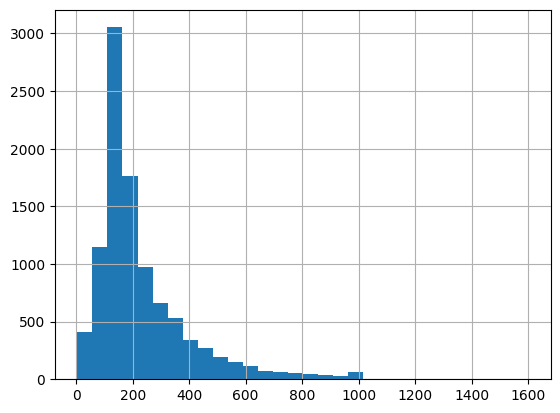

In [4]:
# display distribution of review lengtsh
data['review_length'] = data['review'].apply(lambda x: len(x.split()))
data['review_length'].hist(bins=30)

In [5]:
# delete review length column
del data['review_length']

Looks like dataset has no null values and fairly balanced distribution of positive and negative reviews and reviews make a nice distribution with an average of 170 words. It is a binary classification problem where we will try to predict the sentiment of the review.

### 2. Preprocessing the Data (10 points)

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Define the preprocessing function
def preprocess_text(text):

    # 1) Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    
    # 2) Convert to lowercase
    text = text.lower()
    
    # 3) Remove special characters except spaces, punctuation, and numbers
    text = re.sub(r"[^a-z0-9\s.,!?]", "", text)
    
    # 4) Tokenize using NLTK
    raw_tokens = word_tokenize(text)
    
    # 5) Remove stopwords and lemmatize using spaCy
    doc = nlp(" ".join(raw_tokens))
    final_tokens = [
        token.lemma_  # Lemmatize
        for token in doc
        if not token.is_stop  # Remove stopwords
        and token.lemma_.strip() != ""  # Remove empty tokens
    ]
    return final_tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\algos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\algos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Build the vocabulary using the tokens
# Assign indices to each token in the vocabulary
# Reserve 0 for padding

data['tokens'] = data['review'].apply(preprocess_text)
data['tokens'].head()

from collections import Counter
token_counter = Counter()

for tokens in data['tokens']:
    token_counter.update(tokens)

vocab = {
    token: index + 1
    for index, (token, count) in enumerate(token_counter.most_common())
}



In [8]:
vocab['0'] = 0
vocab[0] = 0

In [9]:
# Calculate the length of each review from the tokenized version
# Display statistical details about review lengths

data['review_length'] = data['tokens'].apply(len)
data['review_length'].describe()

count    10000.000000
mean       128.849500
std         97.135683
min          5.000000
25%         69.000000
50%         96.000000
75%        159.000000
max        950.000000
Name: review_length, dtype: float64

<Axes: >

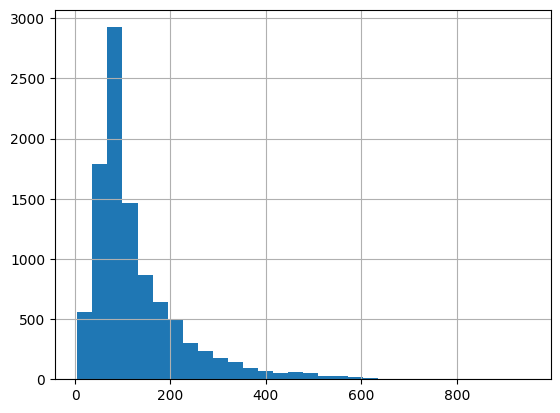

In [10]:
# plot the review length distribution
data['review_length'].hist(bins=30)

In [11]:
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

# 95th percentile
max_length = int(data['review_length'].quantile(0.95))
max_length

332

In [12]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        padded_seq = [0] * (max_len - len(seq)) + seq
    else:
        padded_seq = seq[:max_len] 
    padded_indices = [vocab[token] for token in padded_seq]
    return padded_indices
    

# Add an padded_indices column to store padded sequences

data['padded_indices'] = data['tokens'].apply(pad_sequence, max_len=max_length)

### 3. Visualzing Word Vectors (15 points)

In [14]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [15]:
# Check out for Out-of-Vocaublary (OOV) words
# See how many words in your created vocaublary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

# Identify OOV words
oov_words = [word for word in vocab if word not in fasttext_vectors]
print(f"Number of OOV words: {len(oov_words)}")

# Example: Display some OOV words
print("Sample OOV words:", oov_words[:10])
print(len(vocab))

Number of OOV words: 23725
Sample OOV words: ['lowbudget', 'seagal', 'bmovie', 'overthetop', 'stanwyck', 'miniserie', 'clichs', 'clichd', 'writerdirector', 'carrey']
55824


Word embeddings are a crucial component in natural language processing tasks like sentiment analysis, as they provide a way to represent words numerically in a dense, low-dimensional vector space. These embeddings capture semantic relationships between words, meaning that words with similar meanings (e.g., "happy" and "joyful") are placed closer together in the vector space. By using pre-trained word embeddings like Word2Vec, LSTMs can leverage this rich semantic information to better understand the context and sentiment of text, even when the data is limited. However, one challenge with using pre-trained embeddings is the issue of Out-of-Vocabulary (OOV) words—words that are not present in the embedding's vocabulary. For these words, random or default embeddings are often used, which may lack meaningful semantic information and can introduce noise into the model. To handle OOV words effectively, techniques such as subword embeddings (e.g., fastText) or training embeddings on the specific dataset can be employed, ensuring better representation and improved performance for tasks like sentiment analysis on movie reviews.

In [16]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."

selected_words = [
    "man", "woman", 
    "boy", "girl", 
    "sir", "madam", 
    "father", "mother", 
    "brother", "sister", 
    "king", "queen", 
    "uncle", "aunt", 
    "husband", "wife"
    # "prince", "princess", 
    # "actor", "actress", 
    # "hero", "heroine", 
    # "wizard", "witch", 
    # "god", "goddess", 
    # "he", "she", 
    # "him", "her", 
    # "his", "hers", 
    # "male", "female", 
    # "grandfather", "grandmother", 
    # "nephew", "niece", 
    # "son", "daughter", 
    # "water", "waters", 
    # "mouse", "mice", 
    # "dog", "dogs", 
    # "cat", "cats", 
    # "child", "children", 
    # "person", "people", 
    # "foot", "feet", 
    # "fish", "fishes", 
    # "leaf", "leaves", 
    # "knife", "knives", 
    # "tooth", "teeth", 
    # "man", "men", 
    # "woman", "women", 
    # "ox", "oxen", 
    # "goose", "geese", 
    # "good", "bad", 
    # "happy", "sad", 
    # "amazing", "terrible", 
    # "excellent", "poor", 
    # "great", "awful", 
    # "positive", "negative", 
    # "boring", "exciting", 
    # "strong", "weak", 
    # "beautiful", "ugly", 
    # "rich", "poor", 
    # "kind", "cruel", 
    # "brave", "cowardly", 
    # "clean", "dirty", 
    # "fast", "slow", 
    # "hot", "cold", 
    # "hard", "soft", 
    # "tall", "short", 
    # "light", "dark", 
    # "run", "ran", 
    # "eat", "ate", 
    # "drink", "drank", 
    # "go", "went", 
    # "see", "saw", 
    # "write", "wrote", 
    # "read", "read", 
    # "sing", "sang", 
    # "bring", "brought", 
    # "swim", "swam", 
    # "think", "thought", 
    # "teach", "taught", 
    # "catch", "caught", 
    # "buy", "bought", 
    # "feel", "felt", 
    # "sit", "sat", 
    # "turkish", "german", 
    # "french", "italian", 
    # "spanish", "russian", 
    # "chinese", "japanese", 
    # "british", "american", 
    # "indian", "pakistani", 
    # "arab", "persian", 
    # "african", "european", 
    # "australian", "canadian", 
    # "love", "hate", 
    # "truth", "lie", 
    # "day", "night", 
    # "summer", "winter", 
    # "yes", "no", 
    # "up", "down", 
    # "left", "right", 
    # "open", "close", 
    # "big", "small", 
    # "young", "old", 
    # "start", "end", 
    # "win", "lose", 
    # "success", "failure", 
    # "war", "peace", 
    # "black", "white", 
    # "friend", "enemy", 
    # "life", "death", 
    # "happy", "angry"
]

selected_words = [word for word in selected_words if word in fasttext_vectors]
print(f"Selected words for visualization: {selected_words}")

Selected words for visualization: ['man', 'woman', 'boy', 'girl', 'sir', 'madam', 'father', 'mother', 'brother', 'sister', 'king', 'queen', 'uncle', 'aunt', 'husband', 'wife']


In [17]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).

word_vectors = [fasttext_vectors[word] for word in selected_words]

In [18]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize

from sklearn.decomposition import PCA

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

# Check the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.23581858 0.18626164]


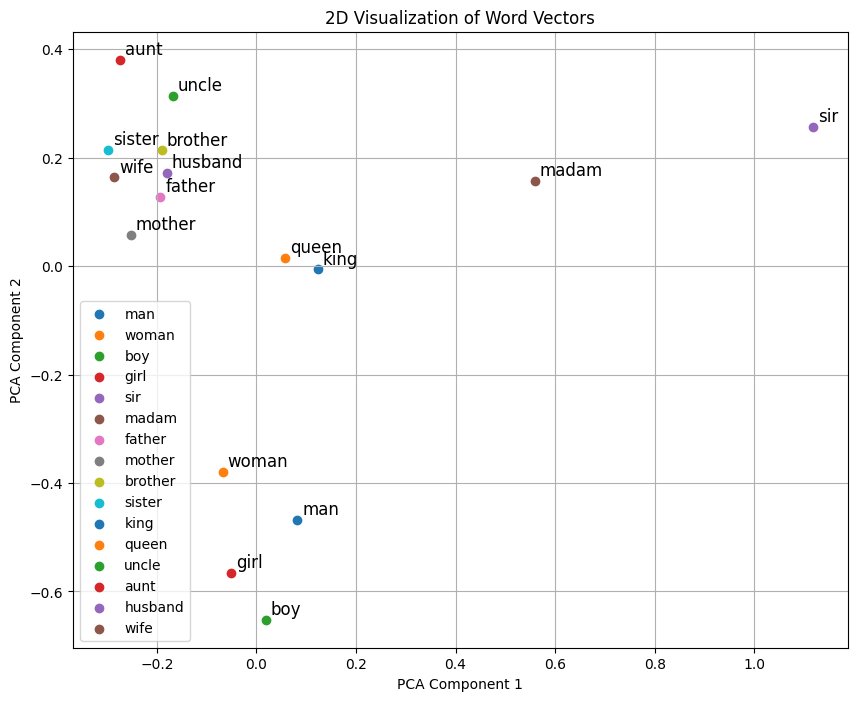

Explained variance ratio for 3D PCA: [0.23581858 0.18626164 0.14379603]


In [19]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
# For 3D visualization, use interactive plotting tools like matplotlib’s Axes3D to explore the spatial relationships between words dynamically.

import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 8))
for i, word in enumerate(selected_words):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=word)
    plt.text(reduced_vectors[i, 0] + 0.01, reduced_vectors[i, 1] + 0.01, word, fontsize=12)

plt.title("2D Visualization of Word Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.legend()
plt.show()


# Reduce dimensionality to 3D
pca_3d = PCA(n_components=3)
reduced_vectors_3d = pca_3d.fit_transform(word_vectors)  # word_vectors is the list of vectors for selected words

# Check the explained variance ratio
print("Explained variance ratio for 3D PCA:", pca_3d.explained_variance_ratio_)

import plotly.express as px
import pandas as pd

# Prepare data for Plotly
df = pd.DataFrame(reduced_vectors_3d, columns=["PCA1", "PCA2", "PCA3"])
df['word'] = selected_words

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df, x="PCA1", y="PCA2", z="PCA3", text="word", title="3D Word Vector Visualization")
fig.update_traces(marker=dict(size=8))
fig.show()

Looking at above plots (they are simplified to just gendered terms to better see in this example), we can clearly see a direction which represents gender. Going litle right and down gives us the feminine words and going left and up gives us the masculine words. This is a clear example of how word embeddings can capture semantic relationships between words.

When we don't simplify the plots we can see how similar words bunch together. Like when country names are added to the plot, we can see that they are all close to each other. This is because they are used in similar context and have similar meanings. This is the power of word embeddings.

### 4. Creating the Emebdding Matrix (10 points)

In [20]:
def create_embedding_matrix(word2vec, vocab, embedding_dim):
    # Initialize the embedding matrix with zeros
    vocab_size = len(vocab)+10
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, index in vocab.items():
        if word in word2vec: 
            embedding_matrix[index] = word2vec[word]   
        else:
            embedding_matrix[index] = np.random.uniform(-0.01, 0.01, embedding_dim)

    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors

In [21]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer

embedding_dim = 300

embedding_matrix = create_embedding_matrix(fasttext_vectors, vocab, embedding_dim)

# Convert the embedding matrix to a PyTorch tensor
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)

### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [22]:
# Train, validation and test split

from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.6666, random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 7000, Validation size: 1000, Test size: 2000


In [23]:
# Implement the dataset class
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.

from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.reviews = data['padded_indices'].tolist()
        self.labels = data['sentiment'].tolist()

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
            review = torch.tensor(self.reviews[idx], dtype=torch.long)
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return review, label

In [24]:
# Create the train, validation and test dataLoaders
from torch.utils.data import DataLoader

train_dataset = IMDBDataset(train_data)
val_dataset = IMDBDataset(val_data)
test_dataset = IMDBDataset(test_data)


batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [25]:
# Manually implement the LSTM cell to understand its architecture and functionality.
# Implement forget, input, and output gates.
# Update the cell state and compute the hidden state for each time step.
# Explain your steps and usage of the gates
# Check assignment pdf for more detail on implementation tips

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)  
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)  
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size) 
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        combined = torch.cat((x_t, h_prev), dim=1)

        # Forget gate
        f_t = torch.sigmoid(self.W_f(combined))

        # Input gate
        i_t = torch.sigmoid(self.W_i(combined))
        c_tilde = torch.tanh(self.W_c(combined))

        # Cell state update
        c_t = f_t * c_prev + i_t * c_tilde

        # Output gate
        o_t = torch.sigmoid(self.W_o(combined))
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

In [26]:
# Build an LSTM layer by combining one or multiple LSTM cells to process a sequence.

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        outputs = []

        # Iterate 
        for t in range(seq_len):
            x_t = x[:, t, :]  
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
            outputs.append(h_t)

        outputs = torch.stack(outputs, dim=1)
        return outputs

In [27]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.lstm = LSTMLayer(embedding_dim, hidden_size)

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through the embedding layer
        embedded = self.embedding(x)

        lstm_out = self.lstm(embedded)
        last_hidden_state = lstm_out[:, -1, :]

        # Pass through the fully connected layer
        output = self.fc(last_hidden_state)
        output = self.sigmoid(output)

        return output

In [28]:
# Define the hyperparameters and try to optimize your model by experimenting with these
input_size = 300  # Word vector size
hidden_size = 128  # Number of LSTM units
learning_rate = 0.001
batch_size = 128
epochs = 50

input size is choosen 300 because our word embeddings are 300 dimensional. Batch size is choosen 128 because model is not too big and running with higher batch sizes will not be a problem and will actually make model faster.

In [29]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
model = SentimentLSTM(len(vocab), input_size, hidden_size, 1, embedding_tensor).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
val_losses = []
val_accuracies = []
train_losses = []
train_accuracies = []

In [32]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance
best_accuracy = 0
total_mode_time = 0
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    time1 = time.time()
    for reviews, labels in train_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(reviews)
        labels = labels.unsqueeze(1)
        correct += (torch.round(outputs) == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)
    train_accuracy = correct / len(train_data)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for reviews, labels in val_loader:
            reviews, labels = reviews.to(device), labels.to(device)
            outputs = model(reviews)
            labels = labels.unsqueeze(1)
            correct += (torch.round(outputs) == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / len(val_data)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

    time2 = time.time() - time1
    print(f"Epoch {epoch+1} completed. Time taken: {time2:.2f}s", end=" ")
    print(f"Train loss: {train_losses[-1]:.4f}, Train accuracy: {train_accuracies[-1]:.4f}", end=" ")
    print(f"Validation loss: {val_losses[-1]:.4f}, Validation accuracy: {val_accuracies[-1]:.4f}")


Epoch 1 completed. Time taken: 53.94s Train loss: 0.6649, Train accuracy: 0.6179 Validation loss: 0.6171, Validation accuracy: 0.6570
Epoch 2 completed. Time taken: 54.06s Train loss: 0.3731, Train accuracy: 0.8464 Validation loss: 0.4164, Validation accuracy: 0.8360
Epoch 3 completed. Time taken: 53.67s Train loss: 0.1349, Train accuracy: 0.9547 Validation loss: 0.5047, Validation accuracy: 0.8090
Epoch 4 completed. Time taken: 53.43s Train loss: 0.0558, Train accuracy: 0.9851 Validation loss: 0.5780, Validation accuracy: 0.8380
Epoch 5 completed. Time taken: 53.94s Train loss: 0.0243, Train accuracy: 0.9951 Validation loss: 0.6427, Validation accuracy: 0.8470
Epoch 6 completed. Time taken: 53.67s Train loss: 0.0129, Train accuracy: 0.9980 Validation loss: 0.7093, Validation accuracy: 0.8400
Epoch 7 completed. Time taken: 54.25s Train loss: 0.0173, Train accuracy: 0.9967 Validation loss: 0.7270, Validation accuracy: 0.8410
Epoch 8 completed. Time taken: 53.35s Train loss: 0.0071, Trai

KeyboardInterrupt: 

# Early Stopped because train accuracy reached almost 100% and validation accuracy stopped increasing.

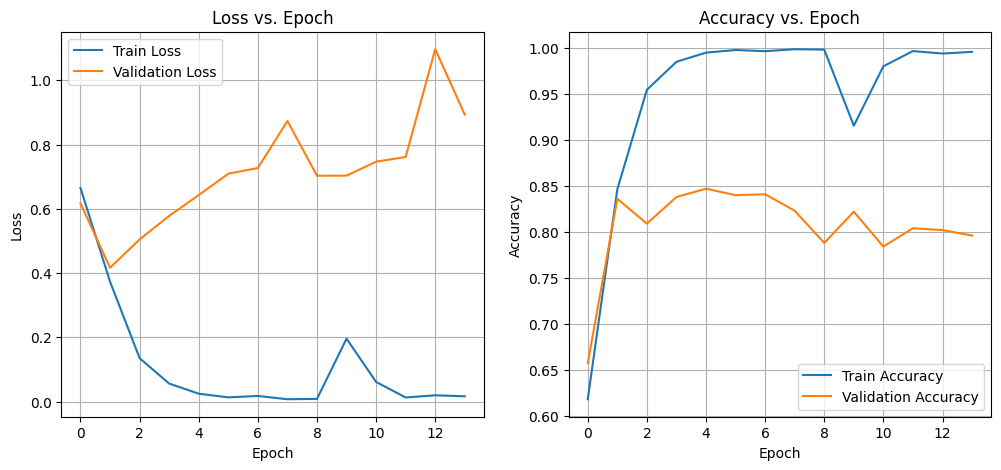

In [33]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid()
plt.show()

### 7. Testing and Analysis (15 points)

In [34]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.

model.load_state_dict(torch.load("best_model.pth"))

model.eval()
test_loss = 0
correct = 0
predictions = []
actuals = []
with torch.no_grad():
    for reviews, labels in test_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        outputs = model(reviews)
        labels = labels.unsqueeze(1)
        correct += (torch.round(outputs) == labels).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predictions.extend(torch.round(outputs).squeeze(1).tolist())
        actuals.extend(labels.squeeze(1).tolist())
test_loss = test_loss / len(test_loader)
test_accuracy = correct / len(test_data)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)
f1 = f1_score(actuals, predictions)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")

C:\Users\algos\AppData\Local\Temp\ipykernel_16944\1464743993.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Loss: 0.6423, Test Accuracy: 0.8390
Test Precision: 0.8415, Test Recall: 0.8465, Test F1 Score: 0.8440


Looking at the results, we see that model overfits to training data in just 5 epochs. As musch as this is not a good thing, we still reach a 85% accuracy on test data which is a good result. We can try to use dropout layers to prevent overfitting but it is not necessary in this case. We can also try to use a simpler model to prevent overfitting but this will decrease our accuracy. So, we can say that this is a good result for this model.

Biggest challenge in this task was word embedding as our vocabolary had lots of OOV words and we had to use a custom word embedding layer. This was a good experience as we learned how to create a custom word embedding layer and how to use it in a model.

In [38]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

model_path = './best_model.pth'  # Replace with your model's path
model = SentimentLSTM(len(vocab), input_size, hidden_size, 1, embedding_tensor).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Step 1: Load the test data
test_file_path = 'subset1000_IMDB_Dataset.csv'  # Adjust this to the test dataset file path
test_data = pd.read_csv(test_file_path)

# Predefine tokenizer and other preprocessing utilities (reuse from training)

# Step 2: Preprocess the test data, apply the steps used during training (change according to your implementation)
test_data["cleaned_tokens"] = test_data["review"].apply(preprocess_text)
padded_test = test_data["cleaned_tokens"].apply(lambda x: pad_sequence(x, max_length)) # Replace with the maximum sequence length used during training

# Convert to PyTorch tensor
test_tensor = torch.tensor(padded_test, dtype=torch.long).to(device)



# Step 4: Predict sentiment for the test reviews
batch_size = 128
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch)
        preds = torch.round(outputs).squeeze().tolist()
        predictions.extend(preds)

# Step 5: Map predicted class labels to corresponding class names
class_labels = {0: 'negative', 1: 'positive'}

# Step 6: Save predictions to CSV file
df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'sentiment': [class_labels[p] for p in predictions]})
df.to_csv('predictions.csv', index=False)


C:\Users\algos\AppData\Local\Temp\ipykernel_16944\137133447.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



My kaggle score is %95 which when multiplied by 5*0.95 = 4.75